In [1]:
# import libraries

import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import osmnx as ox
import pandana
import pandas as pd
from shapely.geometry import Point

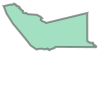

In [2]:
# Set the area of analysis: Alameda County

alameda_gdf = ox.geocode_to_gdf('Alameda County, CA')
alameda_polygon = alameda_gdf["geometry"].iloc[0]
alameda_polygon

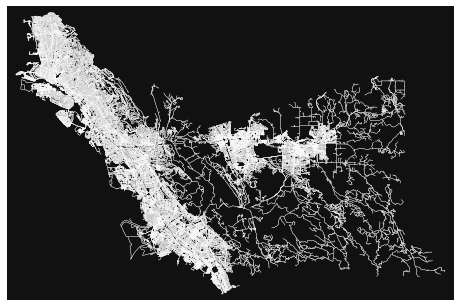

In [3]:
# Model the walking network for the area

G_walk = ox.graph_from_polygon(alameda_polygon, network_type='walk')
fig, ax = ox.plot_graph(G_walk, node_size=0, edge_color='w', edge_linewidth=0.3)

In [4]:
# set a uniform walking speed of 4.5 kph on every edge

for u, v, data in G_walk.edges(data=True):
    data['speed_kph'] = 4.5
G_walk = ox.add_edge_travel_times(G_walk)

In [5]:
# extract node/edge GeoDataFrames, retaining only necessary columns (for pandana)

nodes = ox.graph_to_gdfs(G_walk, edges=False)[['x', 'y']]
edges = ox.graph_to_gdfs(G_walk, nodes=False).reset_index()[['u', 'v', 'travel_time']]

In [6]:
parks = ox.geometries_from_bbox(north=nodes['y'].max(),
                                    south=nodes['y'].min(),
                                    east=nodes['x'].min(),
                                    west=nodes['x'].max(),
                                    tags={'leisure': 'park'})
print(parks.shape)
parks.head()

(1138, 82)


geometry created_by leisure source  \
element_type osmid                                                              
node         358768148  POINT (-122.13608 37.47466)        NaN    park    NaN   
             358769719  POINT (-122.10663 37.65715)        NaN    park    NaN   
             358770907  POINT (-121.96468 37.54521)        NaN    park    NaN   
             358776253  POINT (-122.07052 37.64299)        NaN    park    NaN   
             358817716  POINT (-122.04441 37.65521)        NaN    park    NaN   

                        ele gnis:county_id gnis:created gnis:feature_id  \
element_type osmid                                                        
node         358768148    4            081   01/19/1981          226033   
             358769719   18            001   01/19/1981          227630   
             358770907   19            001   01/19/1981          228851   
             358776253   17            001   01/19/1981          234897   
             358817716  205            001   03/20/1996         1675947   

                       gnis:state_id                  name  ... hist_name  \
element_type osmid                                          ...             
node         358768148            06     Jack Farrell Park  ...       NaN   
             358769719            06         Longwood Park  ...       NaN   
             358770907            06     Mission View Park  ...       NaN   
             358776253            06       Sorensdale Park  ...       NaN   
             358817716            06  College Heights Park  ...       NaN   

                       start_date leisure_1 noname swimming_pool csp:globalid  \
element_type osmid                                                              
node         358768148        NaN       NaN    NaN           NaN          NaN   
             358769719        NaN       NaN    NaN           NaN          NaN   
             358770907        NaN       NaN    NaN           NaN          NaN   
             358776253        NaN       NaN    NaN           NaN          NaN   
             358817716        NaN       NaN    NaN           NaN          NaN   

                       csp:unitcode protect_class abandoned:leisure natural  
element_type osmid                                                           
node         358768148          NaN           NaN               NaN     NaN  
             358769719          NaN           NaN               NaN     NaN  
             358770907          NaN           NaN               NaN     NaN  
             358776253          NaN           NaN               NaN     NaN  
             358817716          NaN           NaN               NaN     NaN  

[5 rows x 82 columns]

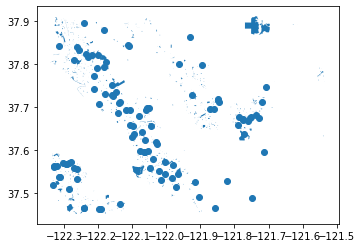

In [7]:
parks.plot();

In [8]:
# construct the pandana network model

network = pandana.Network(node_x=nodes['x'],
                          node_y=nodes['y'], 
                          edge_from=edges['u'],
                          edge_to=edges['v'],
                          edge_weights=edges[['travel_time']])

Generating contraction hierarchies with 12 threads.
Setting CH node vector of size 132189
Setting CH edge vector of size 366610
Range graph removed 376428 edges of 733220
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


In [9]:
# extract (approximate, unprojected) centroids from the amenities' geometries

centroids = parks.centroid

/var/folders/0p/d58gfby91zv_mj3nb5kz5_9c0000gn/T/ipykernel_67677/2258557667.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = parks.centroid


In [10]:
# specify max travel distance for the analysis
# then set the park locations on the network

maxdist = 15 * 60  # 15 minutes converted to seconds
network.set_pois(category='parks',
                 maxdist=maxdist,
                 maxitems=3,
                 x_col=centroids.x, 
                 y_col=centroids.y)

/Users/brooks/opt/anaconda3/envs/parkaccess/lib/python3.9/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/Users/brooks/opt/anaconda3/envs/parkaccess/lib/python3.9/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


In [11]:
# calculate travel time to nearest park from each node in network
distances = network.nearest_pois(distance=maxdist,
                                 category='parks',
                                 num_pois=3)
distances.astype(int).head()

1    2    3
osmid                  
30366200  242  427  500
32972114  325  396  900
32972116  390  460  900
32972118  450  520  900
32972120  511  582  868

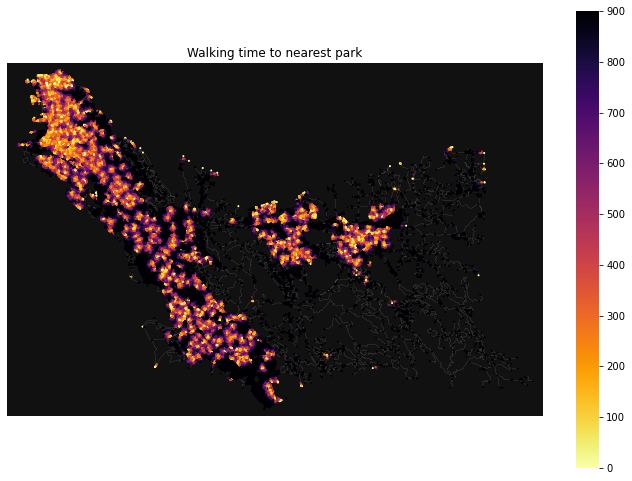

In [12]:
# plot distance to nearest park

fig, ax = ox.plot_graph(G_walk, node_size=0, edge_linewidth=0.1,
                        edge_color='gray', show=False, close=False,
                        figsize=(12,12)
                       )

sc = ax.scatter(x=nodes['x'],
                y=nodes['y'], 
                c=distances[1],
                s=1,
                cmap='inferno_r')

ax.set_title(f'Walking time to nearest park')
plt.colorbar(sc, shrink=0.7).outline.set_edgecolor('none')

In [25]:
# select the nodes in the network where parks are located
node_ids = network.get_node_ids(centroids.x, centroids.y)

# set a variable related to the park nodes in the network
network.set(node_ids, name='parks')

# calculate the variable for every origin node in the network
# as the number of park nodes within a maximum distance of it
access = network.aggregate(distance=maxdist,
                           type='count',
                           decay='linear',
                           name='parks'
                          )

# Cap the variable at 5 parks
access= access.clip(upper=5)

access.describe()

count    132189.000000
mean          2.014192
std           1.820690
min           0.000000
25%           0.000000
50%           2.000000
75%           3.000000
max           5.000000
dtype: float64

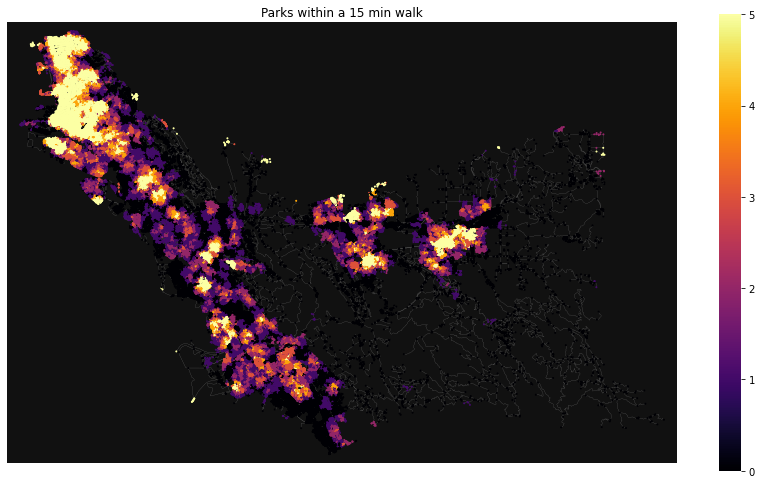

In [28]:
# plot the number of parks within 15 min walking distance
# of each node in the network

fig, ax = ox.plot_graph(G_walk, 
                        node_size=0, 
                        edge_linewidth=0.1,
                        edge_color='gray',
                        show=False,
                        close=False,
                        figsize=(15,12)
                       )

sc = ax.scatter(x=nodes['x'],
                y=nodes['y'],
                c=access,
                s=1,
                cmap='inferno')

ax.set_title('Parks within a 15 min walk')
plt.colorbar(sc, shrink=0.7).outline.set_edgecolor('none')

In [34]:
# We now have a Pandas Series for the park access variable 
# (i.e. number of parks within walking distance) 
# indexed by node ids from the Pandana network.

access.head()

osmid
30366200    5.0
32972114    2.0
32972116    2.0
32972118    2.0
32972120    3.0
dtype: float64

In [36]:
# We could figure out the location of each node by accessing 
# the nodes gdf created above

nodes.head()

x          y
osmid                          
30366200 -122.280475  37.828248
32972114 -122.094664  37.652641
32972116 -122.094231  37.652005
32972118 -122.093787  37.651431
32972120 -122.093296  37.650857